# Hamiltonian Simulation

Schrodinger's Equation
$$\begin{align}
i\sout{h}\frac{d}{dt}\ket{\psi} = H\ket{\psi} \implies \ket{\psi(t)} = e^{-iHt}\ket{\psi(0)}
\end{align}$$

Because H is hermitian, $e^{\frac{-iHt}{\sout{h}}}$ is unitary

The strategy is to break H into a sum of Pauli strings and then use Trotter's Formula on them to get gates that look like $e^{-iZT}$ or $e^{-iXT}$


In [177]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator
from scipy.sparse import random
import itertools

Let's start with an arbitrary hamiltonian

In [227]:
n = 3 #number of qubits
t = 2
def generate_sparse_hamiltonian(num_qubits):
    random_sparse_matrix = random(2**n, 2**n, density=0.1).toarray()
    hermitian_matrix = random_sparse_matrix + random_sparse_matrix.conj().T
    return Operator(hermitian_matrix)

In [228]:
H = generate_sparse_hamiltonian(n)

Now we want to decompose the Hamiltonian to a sum of Pauli strings. $H = \sum_{k=1}^{2^n}(c_k\sigma_k)$, where $\sigma_k$ is a pauli string e.g. $\sigma_1 = I \otimes I...\otimes I$ and $\sigma_3 = I \otimes I...\otimes Y$

Now we have to calculate $c_k$'s. 

We know that $I*I = X*X = Y*Y = Z*Z = I$

So, $\sigma_k * H = c_k I \otimes I ... \otimes I + \sum_{k' \ne k} \sigma_kc_{k'}\sigma_{k'}$

$\implies c_k = \frac{1}{2^n}Tr(\sigma_k * H)$

In [229]:
#generate all possible pauli strings for n qubits
def generate_all_pauli_strings(num_qubits):
    pauli_list = ['I', 'X', 'Y', 'Z']
    all_pauli_strings = [list(s) for s in itertools.product(pauli_list, repeat=num_qubits)]
    for i in range(len(all_pauli_strings)):
        s = ''
        for j in range(num_qubits):
            s += all_pauli_strings[i][j]
        all_pauli_strings[i] = SparsePauliOp(s)
    return all_pauli_strings

def compute_pauli_string_coefficients(H):
    n = int(np.log2(H.to_matrix().shape[0]))
    pauli_strings = generate_all_pauli_strings(n)
    coefficients = {}
    for s in pauli_strings:
        c = (2**-n)*np.trace(np.dot(s.to_matrix(), H.to_matrix()))
        if c != 0:
            coefficients[str(s.paulis[0])] = c
    return coefficients

In [230]:
coeffs = compute_pauli_string_coefficients(H)

In [231]:
#check that the coefficients are correct
np.array_equal(SparsePauliOp(list(coeffs.keys()), list(coeffs.values())).to_matrix(), H.to_matrix())

True

In [232]:
coeffs

{'XII': (0.3244501998082906+0j),
 'XIZ': (-0.3244501998082906+0j),
 'XXI': (0.07650618644803131+0j),
 'XXX': (0.08696749568322368+0j),
 'XXZ': (-0.03693966296581197+0j),
 'XYY': (0.07217775053253953+0j),
 'XZI': (-0.11137041831420524+0j),
 'XZZ': (0.11137041831420524+0j),
 'YXY': (0.07217775053253953+0j),
 'YYI': (-0.07650618644803131+0j),
 'YYX': (-0.08696749568322368+0j),
 'YYZ': (0.03693966296581197+0j)}

Now, $e^{-iHt} = e^{-i\sum_k c_k\sigma_kt} = \Pi_{k} e^{-ic_k\sigma_kt}$

So, if we can implement individual unitaries, we can simulate the Hamiltonian approximately.

Let's try to simulate this - $e^{i Z \otimes Z t}$

Consider the following circuit for this purpose

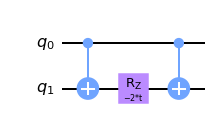

In [181]:
qc = QuantumCircuit(2)
p = Parameter('t')
qc.cx(0,1)
qc.rz(-2*p, 1)
qc.cx(0,1)
qc.draw("mpl")

We can write $e^{iZ \otimes Zt} = cos(t)I + isin(t)I\otimes Z$ \
\
This circuit is $CNOT(I \otimes e^{iZt})CNOT = [\ket{0}\bra{0} \otimes I + \ket{1}\bra{1} \otimes X][cos(t)I \otimes I + isin(t)I \otimes Z][\ket{0}\bra{0} \otimes I + \ket{1}\bra{1} \otimes X] = cos(t)I + i sin(t)Z \otimes Z$

For $e^{iZ \otimes Z \otimes Zt}$, we can make the following circuit

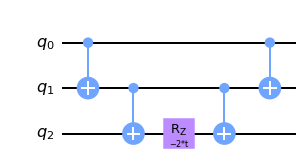

In [182]:
qc = QuantumCircuit(3)
p = Parameter('t')
qc.cx(0,1)
qc.cx(1,2)
qc.rz(-2*p, 2)
qc.cx(1,2)
qc.cx(0,1)
qc.draw("mpl")

And this generalizes to n terms. 

If we hava an $X$ term in the product, let $P_1$ and $P_2$ be Pauli strings before and after the X. Then we can write

$e^{iP_1 \otimes X \otimes P_2t} = cos(t)I + isint(t)P_1 \otimes X \otimes P_2 = cos(t)I + isint(t)P_1 \otimes (HZH) \otimes P_2 = H^{(n)} e^{iP_1 \otimes Z \otimes P_2t} H^{(n)}$

Similarly, for $Y$ term, $Y = H_yZH_y$ and,
$e^{iP_1 \otimes Y \otimes P_2t} = H_y^{(n)} e^{iP_1 \otimes Z \otimes P_2t} H_y^{(n)}$ where
$$
H_y = \frac{1}{\sqrt2}\left(\begin{array}{cc} 
1 & -i\\
i & -1 \\
\end{array}\right)
$$ 

Now, equipped with all of this, let's try to simulate the Hamiltonian

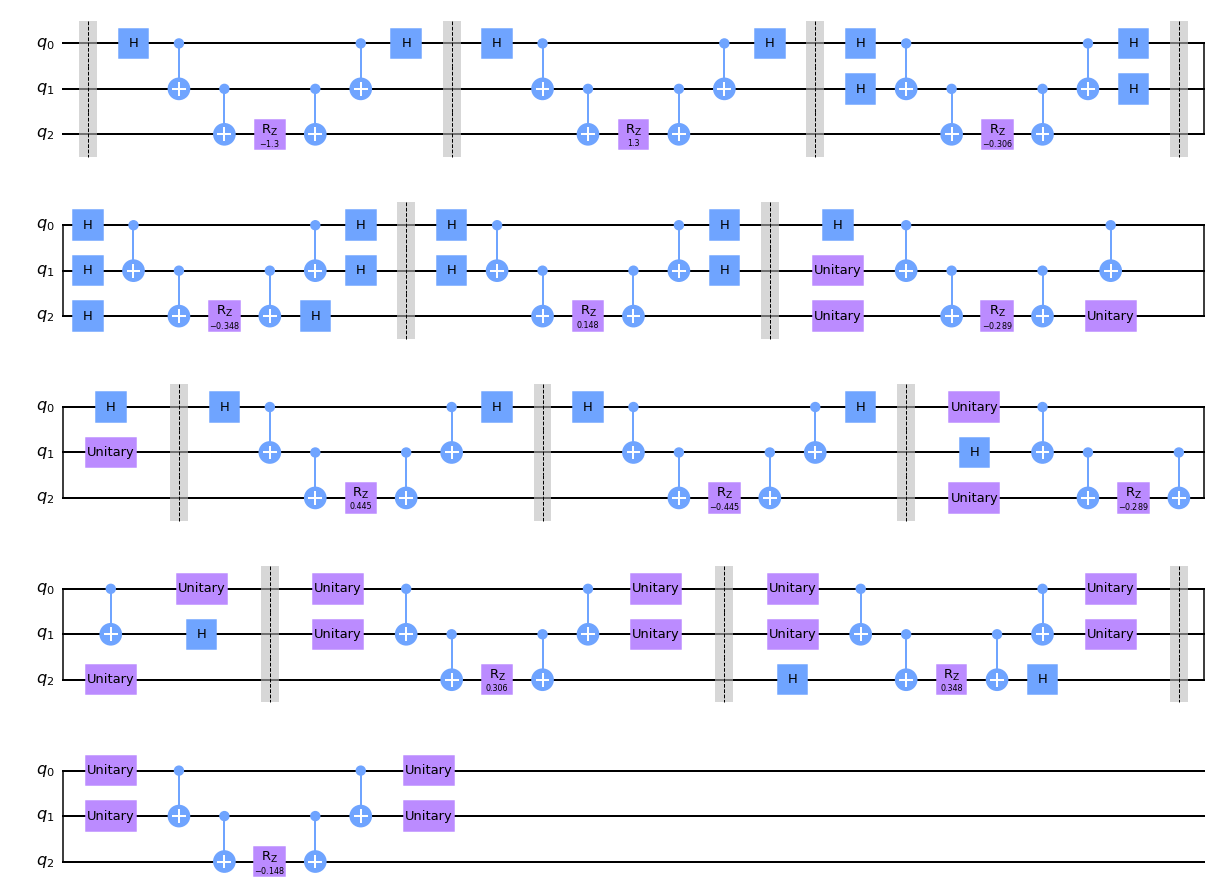

In [241]:
Hy = [[1/np.sqrt(2), -1j/np.sqrt(2)],[1j/np.sqrt(2), -1/np.sqrt(2)]]
Hy = Operator(Hy)
def generate_unitary_from_pauli_strings(coeffs):
    qc = QuantumCircuit(n)
    for s in coeffs:
        qc.barrier()
        c = np.real(coeffs[s]) 
        for qubit in range(len(s)):
            if s[qubit] == 'X':
                qc.h(qubit)
            elif s[qubit] == 'Y':
                qc.append(Hy, [qubit])
        
        for qubit in range(1, len(s)):
            qc.cx(qubit-1, qubit)
        
        qc.rz(-2*t*c, n-1)

        for qubit in range(len(s)-1, 0, -1):
            qc.cx(qubit-1, qubit)

        for qubit in range(len(s)):
            if s[qubit] == 'X':
                qc.h(qubit)
            elif s[qubit] == 'Y':
                qc.append(Hy, [qubit])

        

    
    
    return qc

qc = generate_unitary_from_pauli_strings(coeffs)
qc.draw("mpl")

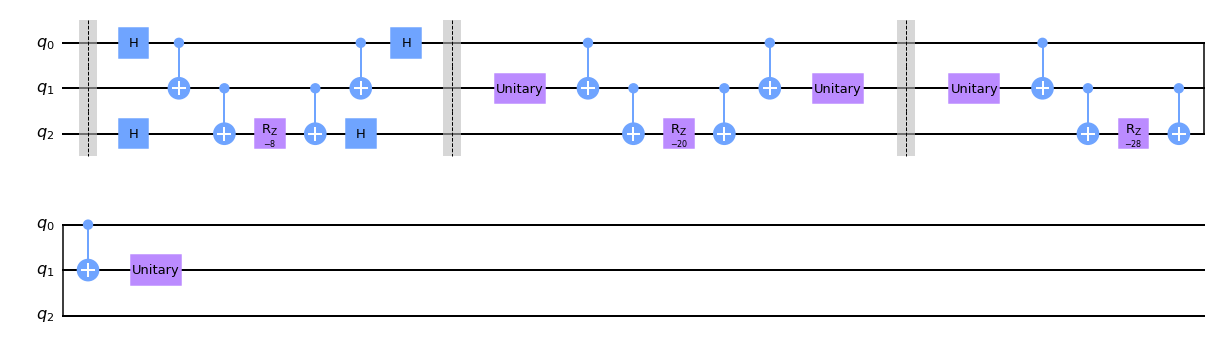

In [242]:
hamiltonian = {"XZX": 2, "ZYI": 5, "IYZ": 7}
qc = generate_unitary_from_pauli_strings(hamiltonian)
qc.draw("mpl")

In [ ]:
#TODO finish this tutorial.....